<a href="https://colab.research.google.com/github/DurdenTyler2008/University-of-AI/blob/main/18_2_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>Обработка аудио </h1>

Добейтесь точности распознавания жанров музыки не менее 79% стабильно на последних эпохах обучения.

Используйте разбивку 900 записей на обучающую выборку и 100 на проверочную

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files 
from tensorflow.keras.utils import to_categorical 
import os 
import sklearn
import librosa
import librosa.display
from tensorflow.keras.callbacks import ReduceLROnPlateau   # callback для уменьшения шага обучения
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

import time
import IPython.display as ipd
from IPython.display import Audio 
from tensorflow.keras.models import load_model
import keras.losses

**Подготовка данныx**

In [3]:
!ls "/content/drive/MyDrive/Audio/genres_all"

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [4]:
genres = os.listdir("/content/drive/MyDrive/Audio/genres_all")
genres

['classical',
 'country',
 'disco',
 'jazz',
 'pop',
 'rock',
 'blues',
 'metal',
 'reggae',
 'hiphop']

In [5]:
path = "/content/drive/MyDrive/Audio/genres_all/jazz/jazz.00099.au"

x, sr = librosa.load(path)               # x - массив данных временного ряда аудио
                                         # sr - частота дискретизации временного ряда
print(type(x), type(sr))
print(x.shape, sr)
print(x.shape[0]/sr)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050
30.013333333333332


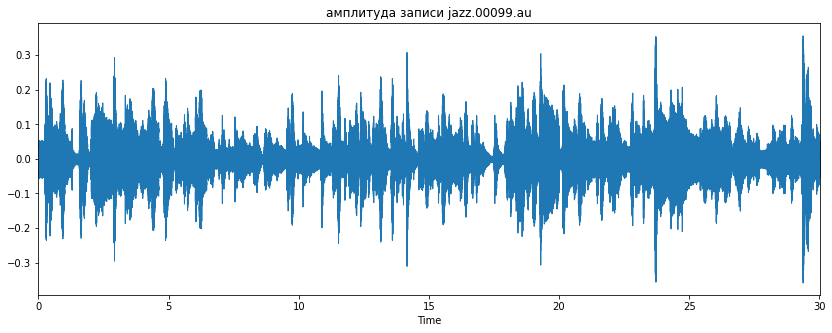

In [6]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)  # амплитуда сигнала
plt.title("амплитуда записи jazz.00099.au")
plt.show()

In [7]:
def get_features_2d(y, sr):

    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)       # частота цветности
    rmse = librosa.feature.rms(y=y)                             # среднеквадратичная амплитуда
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)   # спектральный центроид
    mfcc = librosa.feature.mfcc(y=y, sr=sr)                     # мел спектральные коэффициенты

    return mfcc, chroma_stft, rmse, spec_cent

In [8]:
X_train_mfcc = []
X_train_chroma_stft = []
X_train_rmse = []
X_train_spec_cent = []
Y_train = []

curr_time = time.time()
seconds = 20

for i in range(len(genres)):

    g = genres[i]                                                         # Берём текущий жанр
 
    for filename in os.listdir(f"./drive/MyDrive/Audio/genres_all/{g}"):  # Проходим по файлам папки, соответствующей текущему жанру                     
        songname = f"./drive/MyDrive/Audio/genres_all/{g}/{filename}"     # Получаем имя песни
        y, sr = librosa.load(songname, mono=True, duration=seconds)

        for sec in range(seconds):

            mfcc, chroma_stft, rmse, spec_cent = get_features_2d(y[sec*sr:(sec+1)*sr], sr)
            X_train_mfcc.append(mfcc)
            X_train_chroma_stft.append(chroma_stft)
            X_train_rmse.append(rmse)
            X_train_spec_cent.append(spec_cent)
            Y_train.append(utils.to_categorical(i, len(genres)))

    print("Жанр: ", g, " готов за:", round(time.time() - curr_time), "ceк")
    curr_time = time.time()

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Жанр:  classical  готов за: 77 ceк
Жанр:  country  готов за: 78 ceк
Жанр:  disco  готов за: 79 ceк
Жанр:  jazz  готов за: 75 ceк
Жанр:  pop  готов за: 77 ceк
Жанр:  rock  готов за: 74 ceк
Жанр:  blues  готов за: 77 ceк
Жанр:  metal  готов за: 75 ceк
Жанр:  reggae  готов за: 73 ceк
Жанр:  hiphop  готов за: 77 ceк


In [9]:
X_train_mfcc = np.array(X_train_mfcc)
X_train_chroma_stft = np.array(X_train_chroma_stft)
X_train_rmse = np.array(X_train_rmse)
X_train_spec_cent = np.array(X_train_spec_cent)
Y_train = np.array(Y_train)

In [10]:
X_train_mfcc = X_train_mfcc.reshape(X_train_mfcc.shape[0], X_train_mfcc.shape[1], X_train_mfcc.shape[2], 1)
X_train_chroma_stft = X_train_chroma_stft.reshape(X_train_chroma_stft.shape[0], X_train_chroma_stft.shape[1], X_train_chroma_stft.shape[2], 1)
X_train_rmse = X_train_rmse.reshape(X_train_rmse.shape[0], X_train_rmse.shape[2], X_train_rmse.shape[1])
X_train_spec_cent = X_train_spec_cent.reshape(X_train_spec_cent.shape[0], X_train_spec_cent.shape[2], X_train_spec_cent.shape[1])

In [11]:
print(X_train_mfcc.shape)
print(X_train_chroma_stft.shape)
print(X_train_rmse.shape)
print(X_train_spec_cent.shape)

(20000, 20, 44, 1)
(20000, 12, 44, 1)
(20000, 44, 1)
(20000, 44, 1)


In [12]:
print(Y_train.shape)

(20000, 10)


In [44]:
val_mask = np.random.sample(20000)
train_mask = val_mask < 0.9
val_mask = val_mask >= 0.9

In [46]:
def scale(X):
    min_X = X.min()
    max_X = X.max()
    X = (X - min_X) / (max_X - min_X)
    return X

In [50]:
X_train_mfcc_scaled  = scale(X_train_mfcc)                # нормализую функцией def scale(X)
X_train_chroma_stft_scaled = scale(X_train_chroma_stft)
X_train_rmse_scaled = scale(X_train_rmse)
X_train_spec_cent_scaled  = scale(X_train_spec_cent)

In [55]:
X_train_spec_cent_scaled.shape

(20000, 44, 1)

In [ ]:
# ДАННЫЕ ПОДГОТОВЛЕНЫ, СОЗДАЮ НЕЙРОСЕТЬ

In [56]:
input_mfcc = Input((20, 44, 1))
input_chroma_stft = Input((12, 44, 1))
input_rmse = Input((44, 1))
input_spec_cent = Input((44, 1))

x1 = BatchNormalization()(input_mfcc)
x1 = Conv2D(256, (3, 3), padding="same", activation="elu")(x1)
x1 = Conv2D(256, (3, 3), padding="same", activation="elu")(x1)
x1 = MaxPooling2D(2)(x1)
x1 = Conv2D(128, (3, 3), padding="same", activation="elu")(x1)
x1 = Conv2D(128, (3, 3), padding="same", activation="elu")(x1)
x1 = MaxPooling2D(2)(x1)
x1 = Conv2D(64, (3, 3), padding="same", activation="elu")(x1)
x1 = Conv2D(64, (3, 3), padding="same", activation="elu")(x1)
x1 = Flatten()(x1)

x2 = BatchNormalization()(input_chroma_stft)
x2 = Conv2D(256, (3, 3), padding="same", activation="elu")(x2)
x2 = Conv2D(256, (3, 3), padding="same", activation="elu")(x2)
#x2_gmp_1 = GlobalMaxPooling2D(2)(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Conv2D(128, (3, 3), padding="same", activation="elu")(x2)
x2 = Conv2D(128, (3, 3), padding="same", activation="elu")(x2)
#x2_gmp_3 = GlobalMaxPooling2D(2)(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Conv2D(64, (3, 3), padding="same", activation="elu")(x2)
x2 = Conv2D(64, (3, 3), padding="same", activation="elu")(x2)
#x2_gmp_3 = GlobalMaxPooling2D(2)(x2)
x2 = Flatten()(x2)


x3 = BatchNormalization()(input_rmse)
x3 = Conv1D(256, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(256, 3, padding="same", activation="elu")(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(128, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(128, 3, padding="same", activation="elu")(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(64, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(64, 3, padding="same", activation="elu")(x3)
x3 = Flatten()(x3)

x4 = BatchNormalization()(input_spec_cent)
x4 = Conv1D(256, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(256, 3, padding="same", activation="elu")(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(128, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(128, 3, padding="same", activation="elu")(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(64, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(64, 3, padding="same", activation="elu")(x4)
x4 = Flatten()(x4)

x = concatenate([x1, x2, x3, x4])

x = Dense(128, activation="elu")(x)
x = Dense(10, activation="softmax")(x)

In [57]:
model = Model([input_mfcc, input_chroma_stft, input_rmse, input_spec_cent], x)

In [58]:
model.compile(optimizer=Adam(lr=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

In [59]:
reduce_ = ReduceLROnPlateau(monitor="val_loss")

In [60]:
Y_train[val_mask].shape

(2037, 10)

In [62]:
history = model.fit(
          [X_train_mfcc_scaled[train_mask], 
           X_train_chroma_stft_scaled[train_mask], 
           X_train_rmse_scaled[train_mask], 
           X_train_spec_cent_scaled[train_mask]],
                                       Y_train[train_mask], 
           epochs=10, batch_size=256,
                                        validation_data=(
            [X_train_mfcc_scaled[val_mask], 
             X_train_chroma_stft_scaled[val_mask], 
             X_train_rmse_scaled[val_mask], 
             X_train_spec_cent_scaled[val_mask]], 
                                        Y_train[val_mask]),
                                        callbacks=[reduce_])

Epoch 1/10
71/71 [==============================] - 1679s 24s/step - loss: 2.1150 - accuracy: 0.3285 - val_loss: 6.8107 - val_accuracy: 0.1114
Epoch 2/10
71/71 [==============================] - 1674s 24s/step - loss: 1.0097 - accuracy: 0.6456 - val_loss: 4.8168 - val_accuracy: 0.1060
Epoch 3/10
71/71 [==============================] - 1680s 24s/step - loss: 0.7637 - accuracy: 0.7329 - val_loss: 4.4141 - val_accuracy: 0.2106
Epoch 4/10
71/71 [==============================] - 1683s 24s/step - loss: 0.5989 - accuracy: 0.7917 - val_loss: 5.4046 - val_accuracy: 0.2062
Epoch 5/10
71/71 [==============================] - 1679s 24s/step - loss: 0.4894 - accuracy: 0.8238 - val_loss: 4.5958 - val_accuracy: 0.3348
Epoch 6/10
71/71 [==============================] - 1680s 24s/step - loss: 0.3762 - accuracy: 0.8671 - val_loss: 2.3073 - val_accuracy: 0.5007
Epoch 7/10
71/71 [==============================] - 1676s 24s/step - loss: 0.2465 - accuracy: 0.9149 - val_loss: 1.3043 - val_accuracy: 0.6701

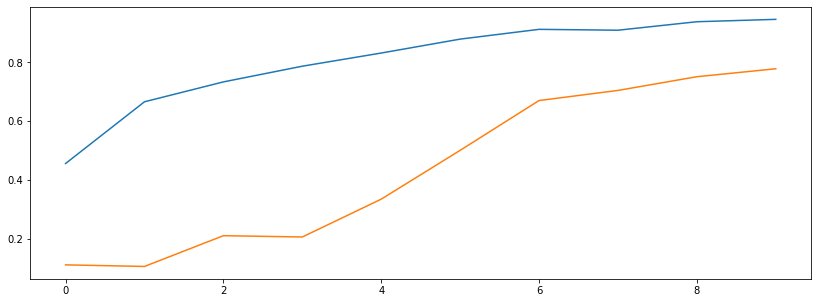

In [63]:
plt.figure(figsize=(14, 5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

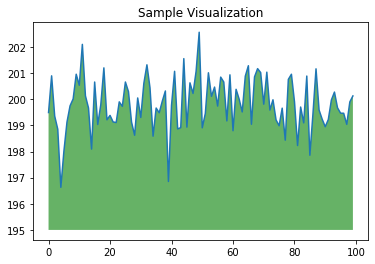

In [64]:
import numpy as np
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Sample Visualization")
plt.show()